<a href="https://colab.research.google.com/github/unmtransinfo/CFChemDb/blob/main/notebooks/CFChemDb_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="200">

# CFChemDb Demo

* https://www.nih-cfde.org/

In this simple CFDE-IDG demo we pull CFChemDb data from AWS EC2 cloud instance, for display, analysis and integration with related entities and datasets.

In [1]:
!pip install psycopg2-binary
import sys,os,json,base64,io,requests,urllib.request
import pandas as pd
import psycopg2,psycopg2.extras
from PIL import Image as PIL_Image
from IPython.display import Image as IPython_Image
from IPython.core.display import display, HTML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 5.8 MB/s 


### Database credentials

In [2]:
dsn = (f"host='unmtid-dbs.net' port='5442' dbname='cfchemdb' user='commoner' password='easement'")
dbcon = psycopg2.connect(dsn)
dbcon.cursor_factory = psycopg2.extras.DictCursor

### Tables and row-counts

In [3]:
tables = pd.read_sql(f"SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'", dbcon)
rowcounts=None;
for tname in tables.table_name:
  df_this = pd.read_sql(f"SELECT COUNT(*) AS rowcount FROM {tname}", dbcon)
  df_this["table"] = tname
  rowcounts = df_this if rowcounts is None else pd.concat([rowcounts, df_this])
rowcounts = rowcounts[["table", "rowcount"]]
rowcounts

,table,rowcount
0,drugcentral,4713
0,glygen,33531
0,idg,251677
0,lincs,32469
0,meta,1
0,mols,311041
0,properties,311041
0,refmet,154676
0,reprotox,965


### Columns

In [4]:
columns=None;
for tname in tables.table_name:
  sql2 = (f"SELECT column_name,data_type FROM information_schema.columns WHERE table_schema = 'public' AND table_name = '{tname}'")
  df_this = pd.read_sql(sql2, dbcon)
  df_this["table"] = tname
  columns = df_this if columns is None else pd.concat([columns, df_this])
columns = columns[["table", "column_name", "data_type"]]
columns

,table,column_name,data_type
0,drugcentral,id,character varying
1,drugcentral,name,character varying
2,drugcentral,cas_reg_no,character varying
3,drugcentral,smiles,character varying
4,drugcentral,inchikey,character varying
...,...,...,...
2,reprotox,pubchem_cid,character varying
3,reprotox,smiles,character varying
4,reprotox,term,character varying
5,reprotox,cansmi,character varying


### Drug from DrugCentral

In [5]:

drug = pd.read_sql("SELECT * FROM drugcentral dc WHERE name = 'ranitidine'", dbcon)
drug.transpose()

,0
id,2358
name,ranitidine
cas_reg_no,66357-35-5
smiles,CNC(NCCSCC1=CC=C(CN(C)C)O1)=C[N+]([O-])=O
inchikey,VMXUWOKSQNHOCA-UHFFFAOYSA-N
inchi,InChI=1S/C13H22N4O3S/c1-14-13(9-17(18)19)15-6-...
formula,C13H22N4O3S
molweight,314.4
cansmi,CNC(=C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1
mol_id,1184


### Depict chemical structure via MOL2IMG from UNM.

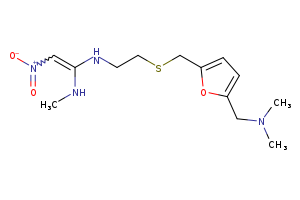

In [6]:
url = f"https://datascience.unm.edu/tomcat/biocomp/mol2img?smiles={urllib.request.quote(drug['smiles'][0])}"
IPython_Image(requests.get(url).content)

### Properties from properties table

In [7]:
drug_props = pd.read_sql(f"SELECT * FROM properties p WHERE mol_id = {drug['mol_id'][0]}", dbcon)
drug_props.transpose()

,0
mol_id,1184.000
mol_wt,314.411
exact_mol_wt,314.141
heavy_atom_mol_wt,292.235
max_abs_partial_charge,0.464
max_partial_charge,0.274
min_abs_partial_charge,0.274
min_partial_charge,-0.464
num_radical_electrons,0.000
num_valence_electrons,118.000


### Similarity search joining LINCS and DrugCentral

In [8]:
results = pd.read_sql("""SELECT
	mols.id,
	mols.cansmi AS smiles,
	drugcentral.id AS dc_id,
	drugcentral.name AS drugname,
	lincs.pert_name AS lincs_name,
	lincs.sig_count,
	ROUND(tanimoto_sml(rdkit_fp(mol_from_smiles('NCCc1ccc(O)c(O)c1'::cstring)), mols.fp)::NUMERIC, 2) similarity
FROM
	mols
JOIN
        drugcentral ON (drugcentral.mol_id = mols.id)
JOIN
	lincs ON (lincs.mol_id = mols.id)
WHERE
	rdkit_fp(mol_from_smiles('NCCc1ccc(O)c(O)c1'::cstring))%mols.fp
ORDER BY
	similarity DESC""", dbcon)
results

,id,smiles,dc_id,drugname,lincs_name,sig_count,similarity
0,1388,CNC[C@H](O)c1ccc(O)c(O)c1,1028,epinephrine,epinephrine,132,0.69
1,254213,CC(N)Cc1ccc(O)cc1,1394,hydroxyamfetamine,hydroxyamphetamine,3,0.66
2,12420,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,1567,levodopa,levodopa,6,0.65
3,740,C=CCc1ccc(O)c(OC)c1,4648,eugenol,eugenol,265,0.64
4,264,CC(C)NC[C@H](O)c1ccc(O)c(O)c1,2388,levisoprenaline,isoprenaline,4,0.63
5,255606,CCNCC(O)c1cccc(O)c1,1101,etilefrine,etilefrine,16,0.57
6,252167,CNCC(O)c1ccc(O)cc1,3577,oxedrine,synephrine,26,0.56
7,1939,C[C@](N)(Cc1ccc(O)c(O)c1)C(=O)O,1762,methyldopa,methyldopa,217,0.56
8,952,CC(C)NCC(O)c1cc(O)cc(O)c1,1720,orciprenaline,orciprenaline,168,0.53
9,259675,C[C@H](N)[C@H](O)c1cccc(O)c1,1721,metaraminol,metaraminol,5,0.53


,id,drugname,img,similarity
0,1388,epinephrine,,0.69
1,254213,hydroxyamfetamine,,0.66
2,12420,levodopa,,0.65
3,740,eugenol,,0.64
4,264,levisoprenaline,,0.63
5,255606,etilefrine,,0.57
6,252167,oxedrine,,0.56
7,1939,methyldopa,,0.56
8,952,orciprenaline,,0.53
9,259675,metaraminol,,0.53

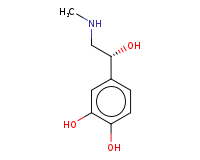
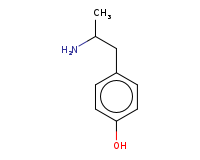
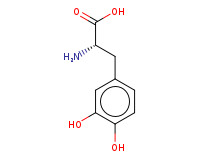
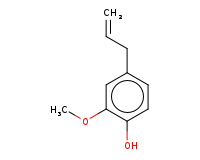
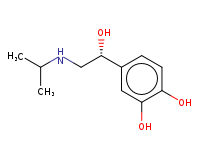
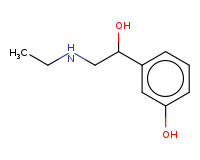
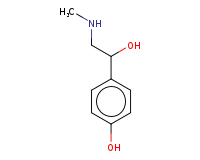
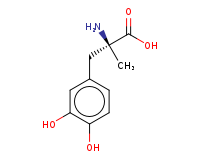
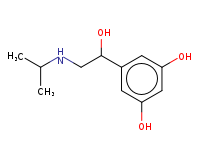
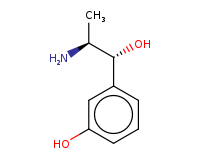
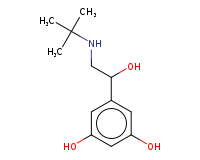

In [17]:
for i,smi in enumerate(results["smiles"]):
  url = f"https://datascience.unm.edu/tomcat/biocomp/mol2img?smiles={urllib.request.quote(smi)}&w=200&h=160"
  img = PIL_Image.open(io.BytesIO(requests.get(url).content))
  w,h = img.size
  img_buffer = io.BytesIO()
  img.save(img_buffer, format="PNG")
  imgStr = base64.b64encode(img_buffer.getvalue()).decode('utf8')
  results.loc[i,'img'] = f"""<img width="{w}" height="{h}" src="data:image/png;base64,{imgStr}">"""
html_all = results[["id", "drugname", "img", "similarity"]].to_html(escape=False)
display(HTML(html_all))